In [3]:
#!/usr/bin/env python
#This file generates chords and arpeggios
#USAGE: python generateScales.py <chordLength> <offsets> <name> (the root note is implied)
#E.g., to generate min7b5 chord: python generateScales.py tetrad 3 3 3 chord min7b5

from midiutil import MIDIFile
import os
import sys
from pathlib import Path
import argparse

In [4]:
def msg2dict(msg):
    result = dict()
    if 'note_on' in msg:
        on_ = True
    elif 'note_off' in msg:
        on_ = False
    else:
        on_ = None
    result['time'] = int(msg[msg.rfind('time'):].split(' ')[0].split('=')[1].translate(
        str.maketrans({a: None for a in string.punctuation})))

    if on_ is not None:
        for k in ['note', 'velocity']:
            result[k] = int(msg[msg.rfind(k):].split(' ')[0].split('=')[1].translate(
                str.maketrans({a: None for a in string.punctuation})))
    return [result, on_]

In [5]:
def switch_note(last_state, note, velocity, on_=True):
    # piano has 88 notes, corresponding to note id 21 to 108, any note out of this range will be ignored
    result = [0] * 88 if last_state is None else last_state.copy()
    if 21 <= note <= 108:
        result[note-21] = velocity if on_ else 0
    return result

In [6]:
def get_new_state(new_msg, last_state):
    new_msg, on_ = msg2dict(str(new_msg))
    new_state = switch_note(last_state, note=new_msg['note'], velocity=new_msg['velocity'], on_=on_) if on_ is not None else last_state
    return [new_state, new_msg['time']]
def track2seq(track):
    # piano has 88 notes, corresponding to note id 21 to 108, any note out of the id range will be ignored
    result = []
    last_state, last_time = get_new_state(str(track[0]), [0]*88)
    for i in range(1, len(track)):
        new_state, new_time = get_new_state(track[i], last_state)
        if new_time > 0:
            result += [last_state]*new_time
        last_state, last_time = new_state, new_time
    return result

In [49]:
def mid2arry(mid, min_msg_pct=0.1):
    tracks_len = [len(tr) for tr in mid.tracks]
    min_n_msg = max(tracks_len) * min_msg_pct
    # convert each track to nested list
    all_arys = []
    for i in range(len(mid.tracks)):
        if len(mid.tracks[i]) > min_n_msg:
            ary_i = track2seq(mid.tracks[i])
            all_arys.append(ary_i)
    # make all nested list the same length
    max_len = max([len(ary) for ary in all_arys])
    for i in range(len(all_arys)):
        if len(all_arys[i]) < max_len:
            all_arys[i] += [[0] * 88] * (max_len - len(all_arys[i]))
    all_arys = np.array(all_arys)
    all_arys = all_arys.max(axis=0)
    # trim: remove consecutive 0s in the beginning and at the end
    sums = all_arys.sum(axis=1)
    ends = np.where(sums > 0)[0]
    return all_arys[min(ends): max(ends)]

In [8]:
def arry2mid(ary, tempo=500000):
    # get the difference
    new_ary = np.concatenate([np.array([[0] * 88]), np.array(ary)], axis=0)
    changes = new_ary[1:] - new_ary[:-1]
    # create a midi file with an empty track
    mid_new = mido.MidiFile()
    track = mido.MidiTrack()
    mid_new.tracks.append(track)
    track.append(mido.MetaMessage('set_tempo', tempo=tempo, time=0))
    # add difference in the empty track
    last_time = 0
    for ch in changes:
        if set(ch) == {0}:  # no change
            last_time += 1
        else:
            on_notes = np.where(ch > 0)[0]
            on_notes_vol = ch[on_notes]
            off_notes = np.where(ch < 0)[0]
            first_ = True
            for n, v in zip(on_notes, on_notes_vol):
                new_time = last_time if first_ else 0
                track.append(mido.Message('note_on', note=n + 21, velocity=v, time=new_time))
                first_ = False
            for n in off_notes:
                new_time = last_time if first_ else 0
                track.append(mido.Message('note_off', note=n + 21, velocity=0, time=new_time))
                first_ = False
            last_time = 0
    return mid_new

In [110]:
import numpy as np
import mido
import string
mid = mido.MidiFile('/home/adecelle/Downloads/nocturne_27_2_(c)inoue.mid', clip=True)
# mid = mido.MidiFile('/home/adecelle/Downloads/piano_sonata_13_2_(c)oguri.mid', clip=True)
# mid = mido.MidiFile('/home/adecelle/Downloads/piano_sonata_332_2_(c)oguri.mid', clip=True)
#mid = mido.MidiFile('/home/adecelle/Downloads/organ_major_works_bwv-565_(c)unknown1.mid', clip=True)
# mid.tracks

In [53]:
for m in mid.tracks[1][:20]:
    print(m)
for s in range(len(mid.tracks)):
    print(len(mid.tracks[s]))

MetaMessage('track_name', name='PIANO', time=0)
MetaMessage('midi_port', port=0, time=0)
MetaMessage('text', text='<RESET>', time=0)
sysex data=(65,16,66,18,64,0,127,0,65) time=0
MetaMessage('text', text='<Master Volume>', time=0)
sysex data=(65,16,66,18,64,0,4,100,88) time=0
MetaMessage('text', text='<Master Reverve>', time=96)
sysex data=(65,16,66,18,64,1,48,3,12) time=0
sysex data=(65,16,66,18,64,1,51,60,80) time=0
sysex data=(65,16,66,18,64,1,52,60,79) time=0
control_change channel=0 control=0 value=0 time=192
control_change channel=0 control=32 value=1 time=2
program_change channel=0 program=0 time=2
control_change channel=0 control=7 value=100 time=98
control_change channel=0 control=11 value=127 time=96
control_change channel=0 control=10 value=64 time=96
control_change channel=0 control=1 value=0 time=96
MetaMessage('text', text='<part reverve>', time=0)
control_change channel=0 control=91 value=90 time=0
control_change channel=0 control=99 value=1 time=48
13
3957
2


In [33]:
result_array = mid2arry(mid)
print(result_array.shape)

(11087, 88)


In [28]:
print(np.where(result_array[0,:]!=0)[0])
print(result_array[0,60])
result_array[:10,50:70]

[60]
102


array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 102,   0,   0,
          0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 102,   0,   0,
          0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 102,   0,   0,
          0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 102,   0,   0,
          0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 102,   0,   0,
          0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 102,   0,   0,
          0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 102,   0,   0,
          0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 102,   0,   0,
          0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 102,  

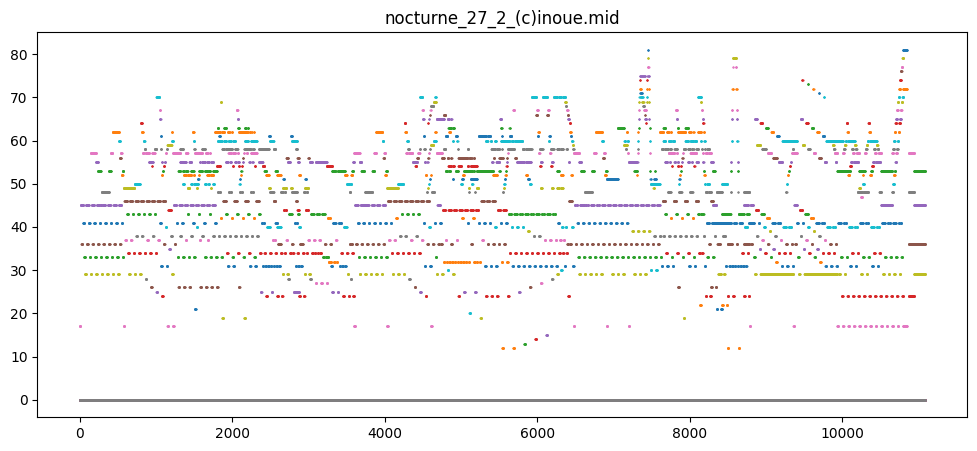

In [111]:
result_array = mid2arry(mid)
import matplotlib.pyplot as plt
plt.figure(figsize=(12,5))
plt.plot(range(result_array.shape[0]), np.multiply(np.where(result_array>0, 1, 0), range(1, 89)), marker='.', markersize=1, linestyle='')
# plt.xlim(0,1000)
plt.title("nocturne_27_2_(c)inoue.mid")
plt.show()

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


<Figure size 1000x3000 with 0 Axes>

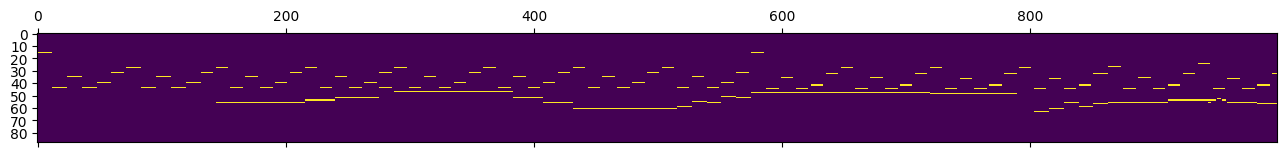

In [112]:
lin_seq = (result_array>0)*1
print(lin_seq)
plt.figure(figsize=(10,30))
plt.matshow(lin_seq[:1000,:].T)

In [267]:
# binning
print(lin_seq.shape)
Δbin = 35
stride = Δbin
m=0
X_seq = []
while (m+Δbin<lin_seq.shape[0]):
    X_seq.append(lin_seq[m:m+Δbin,:].sum(0))
    m += stride
print(len(X_seq))
X_seq = np.array(X_seq).reshape(len(X_seq),88)
X_seq = (X_seq>0)*1
print(X_seq.shape)

(74763, 88)
2136
(2136, 88)


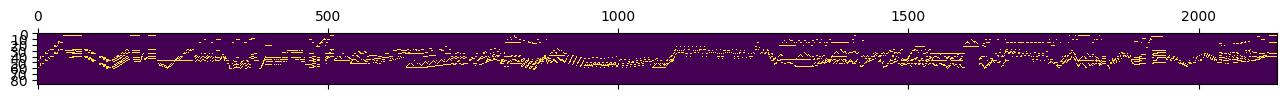

In [268]:
plt.matshow(X_seq.T)

In [269]:
# kernel parameters
# unit = result_array.shape[1]
Δ = 5
stride = 1
s_piano = X_seq.shape[1]

print(X_seq.shape)
M_TOT = X_seq.shape[0] % 10
idx_beg = 0
X = [] # np.zeros((result_array.shape[0]-stride,result_array.shape[1]*Δ))

m=0
while (m+Δ<X_seq.shape[0]):
    X.append(X_seq[m:m+Δ,:].reshape(Δ*s_piano))
    m += stride

#for m in range(M_TOT):
#    Xresult_array[m*Δ:(m+1)*Δ,:]

s_z = len(X)
X = np.array(X).reshape((s_z,s_piano*Δ))
print(len(X))
print(X.shape)

(2136, 88)
2131
(2131, 440)


In [142]:
mid_new = arry2mid(np.repeat(all_X[:2217,:],5,axis=0)*60, 16777215//2)
mid_new.save('mid_new_binned_choping.mid')

Tot Seq= (11087, 88)
Binned Seq= (2217, 88)
Tot Seq= (139660, 88)
Binned Seq= (2793, 88)
Tot Seq= (139666, 88)
Binned Seq= (2793, 88)
Tot Seq= (74763, 88)
Binned Seq= (2136, 88)
(9939, 88)
(9939,)


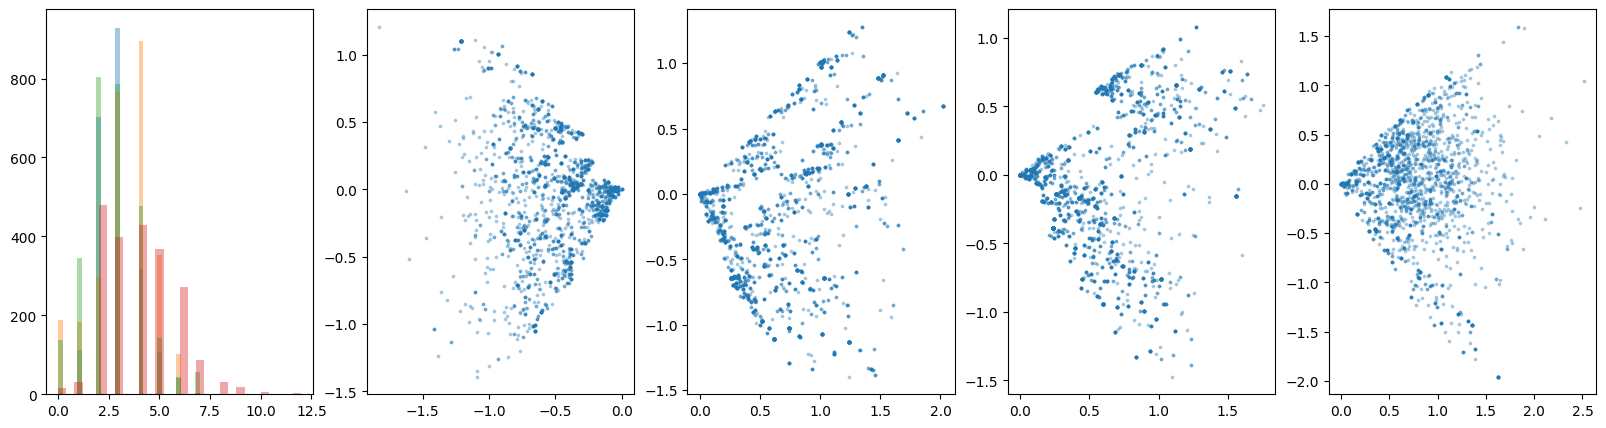

In [114]:
# Create the dataset automatically
l_ΔBins = [5,50,50,35]
l_labels = [b'0',b'1',b'2',b'3']
fnames = ['/home/adecelle/Downloads/nocturne_27_2_(c)inoue.mid',
          '/home/adecelle/Downloads/piano_sonata_13_2_(c)oguri.mid',
          '/home/adecelle/Downloads/piano_sonata_332_2_(c)oguri.mid',
          '/home/adecelle/Downloads/organ_major_works_bwv-565_(c)unknown1.mid']

fig,axes = plt.subplots(1,5,figsize=(20,5))
# fig = plt.figure()
all_X = []
all_y = []

for idx,fn in enumerate(fnames):
    mid = mido.MidiFile(fn, clip=True)
    result_array = mid2arry(mid)
    lin_seq = (result_array>0)*1
    print("Tot Seq=",lin_seq.shape)
    
    # binning
    Δbin = l_ΔBins[idx]
    stride = Δbin
    m=0
    X_seq = []
    while (m+Δbin<lin_seq.shape[0]):
        X_seq.append(lin_seq[m:m+Δbin,:].sum(0))
        m += stride
    # print(len(X_seq))
    X_seq = np.array(X_seq).reshape(len(X_seq),88)
    X_seq = (X_seq>0)*1
    print("Binned Seq=",X_seq.shape)
    X_size = X_seq.shape[0]
    
    # Show stats:
    axes[0].hist(X_seq.sum(1),bins=30,alpha=0.4)
    u,s,v = np.linalg.svd(X_seq)
    Xsc = X_seq @ v.T
    axes[idx+1].scatter(Xsc[:,0],Xsc[:,1],s=3,alpha=0.3)
    
    # str_lab = str(idx)
    data_lab = np.array(l_labels[idx])
    data_lab = data_lab.repeat(X_size)
    
    all_X.append(X_seq)
    all_y.append(data_lab)

all_X = np.concatenate([all_X[i] for i in range(len(all_X))],0)
all_y = np.concatenate([all_y[i] for i in range(len(all_y))],0)
all_X = np.array(all_X)
all_y = np.array(all_y)
print(all_X.shape)
print(all_y.shape)
    

In [101]:
NSamples = all_X.shape[0]
idx_perm = np.random.permutation(NSamples)
all_X = all_X[idx_perm,:]
all_y = all_y[idx_perm]

In [106]:
import h5py 

f=h5py.File('TestFourMasters_Binned.h5','w')
f.create_dataset('train',data=all_X)
f.create_dataset('train_labels',data=all_y)
f.close()

In [201]:
# Create the dataset automatically
# Create the dataset automatically

# lab = [b'0']
# fn = '/home/adecelle/Downloads/nocturne_27_2_(c)inoue.mid'
#          '/home/adecelle/Downloads/piano_sonata_13_2_(c)oguri.mid',
#          '/home/adecelle/Downloads/piano_sonata_332_2_(c)oguri.mid',
#          '/home/adecelle/Downloads/organ_major_works_bwv-565_(c)unknown1.mid']

l_ΔBins = [2,30,30,10]
l_labels = [b'0',b'1',b'2',b'3']
fnames = ['/home/adecelle/Downloads/nocturne_27_2_(c)inoue.mid',
          '/home/adecelle/Downloads/piano_sonata_13_2_(c)oguri.mid',
          '/home/adecelle/Downloads/piano_sonata_332_2_(c)oguri.mid',
          '/home/adecelle/Downloads/organ_major_works_bwv-565_(c)unknown1.mid']

all_X = []
all_y = []
    
for idx,fn in enumerate(fnames):
    mid = mido.MidiFile(fn, clip=True)
    
    result_array = mid2arry(mid)
    lin_seq = (result_array>0)*1
    print("Tot Seq=",lin_seq.shape)

    # binning
    Δbin = l_ΔBins[idx]
    stride = Δbin
    m=0
    X_seq = []
    while (m+Δbin<lin_seq.shape[0]):
        X_seq.append(lin_seq[m:m+Δbin,:].sum(0))
        m += stride
    # print(len(X_seq))
    X_seq = np.array(X_seq).reshape(len(X_seq),88)
    X_seq = (X_seq>0)*1
    print("Binned Seq=",X_seq.shape)
    X_size = X_seq.shape[0]

    # kernel parameters
    # unit = result_array.shape[1]
    Δ = 10
    stride = 1
    s_piano = X_seq.shape[1]

    print(X_seq.shape)
    M_TOT = X_seq.shape[0] % 10
    idx_beg = 0
    X = [] # np.zeros((result_array.shape[0]-stride,result_array.shape[1]*Δ))

    m=0
    while (m+Δ<X_seq.shape[0]):
        X.append(X_seq[m:m+Δ,:].reshape(Δ*s_piano))
        m += stride


    s_z = len(X)
    X = np.array(X).reshape((s_z,s_piano*Δ))
    print(len(X))
    print(X.shape)

    # str_lab = str(idx)
    data_lab = np.array(l_labels[idx])
    data_lab = data_lab.repeat(X.shape[0])
    
    all_X.append(X)
    all_y.append(data_lab)

all_X = np.concatenate([all_X[i] for i in range(len(all_X))],0)
all_y = np.concatenate([all_y[i] for i in range(len(all_y))],0)
all_X = np.array(all_X)
all_y = np.array(all_y)
print(all_X.shape)
print(all_y.shape)

Tot Seq= (11087, 88)
Binned Seq= (5543, 88)
(5543, 88)
5533
(5533, 880)
Tot Seq= (139660, 88)
Binned Seq= (4655, 88)
(4655, 88)
4645
(4645, 880)
Tot Seq= (139666, 88)
Binned Seq= (4655, 88)
(4655, 88)
4645
(4645, 880)
Tot Seq= (74763, 88)
Binned Seq= (7476, 88)
(7476, 88)
7466
(7466, 880)
(22289, 880)
(22289,)


In [202]:
NSamples = all_X.shape[0]
idx_perm = np.random.permutation(NSamples)
all_X = all_X[idx_perm,:]
all_y = all_y[idx_perm]

In [203]:
import h5py 

f=h5py.File('TestFourMasters_Concat10.h5','w')
f.create_dataset('train',data=all_X)
f.create_dataset('train_labels',data=all_y)
f.close()

In [200]:
all_y

array([b'0', b'1', b'1', ..., b'1', b'3', b'3'], dtype='|S1')

In [176]:
Xgen = np.load('/home/adecelle/work/FeF-main/test_piano.npy')
print(Xgen.shape)
mid_new = arry2mid(np.repeat(Xgen[2].reshape(100,88),5,axis=0)*60, 16777215//2)
mid_new.save('gen_mid_choping.mid')


(3000, 8800)


In [169]:
(np.repeat(Xgen[0].reshape(100,88),5,axis=0)*60).dtype

dtype('float32')

In [180]:
#all_data = []
#for in range(3000):
# all_data.append(np.repeat(Xgen[i].reshape(100,88),5,axis=0)*60)
all_data = np.concatenate([np.repeat(Xgen[i].reshape(100,88),5,axis=0)*60 for i in range(30)],0)

In [181]:

mid_new = arry2mid(all_data, 16777215//2)
mid_new.save('gen_mid_choping.mid')